# Local African Ancestry Recognition using chr19 and 1000 Genome as Reference

## Import Libraries

In [1]:
from cyvcf2 import VCF
import pandas as pd
import joblib
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.decomposition import PCA
from datetime import datetime

##  === Define Project Root like Code Ocean root folder ===

In [2]:
project_root = ".."  # base directory: Code Ocean mount point

# === Define Folder Paths ===
data_folder = os.path.join(project_root, "data")
code_folder = os.path.join(project_root, "code")
results_folder = os.path.join(project_root, "results")

files_folder = os.path.join(data_folder, "Files_to_prepare_the_model")
model_folder = os.path.join(results_folder, "Model")
graphs_folder = os.path.join(results_folder, "Graphs")

# Create only subfolders inside results (DO NOT create /results directly!)
for folder in [model_folder, graphs_folder]:
    os.makedirs(folder, exist_ok=True)

# === Timestamp for outputs ===
date = datetime.today().strftime('%Y-%m-%d')

## === Input Files ===

In [3]:
vcf_path = os.path.join(files_folder, "chr19_44903121_44921336_1KGP.vcf.gz")
vcf_index = vcf_path + ".csi"
snp_positions_file = os.path.join(files_folder, "snp_positions_chr19_44903121_44921336.tsv")
kgp_file = os.path.join(files_folder, "list_of_no_relatives_1KGP.tsv")
metadata_file = os.path.join(files_folder, "igsr_samples.tsv")

# === Step 2: Load and Filter Model SNPs ===
importance_df = pd.read_csv(snp_positions_file, sep='\t')
importance_df['SNP'] = importance_df['CHROM'].astype(str) + "_" + importance_df['POS'].astype(str)
model_snp_set = set(importance_df['SNP'])

vcf = VCF(vcf_path)
vcf_snps = set(f"{v.CHROM}_{v.POS}" for v in vcf)
common_snps = model_snp_set & vcf_snps

filtered_snp_df = pd.DataFrame([snp.split('_') for snp in sorted(common_snps)], columns=['CHROM', 'POS'])
filtered_snp_path = os.path.join(model_folder, f"filtered_snps_{date}.tsv")
filtered_snp_df.to_csv(filtered_snp_path, sep='\t', index=False)

# === Step 3: Reload VCF for Common SNPs ===
vcf = VCF(vcf_path)
allele_records = []

for variant in vcf:
    snp_id = f"{variant.CHROM}_{variant.POS}"
    if snp_id not in common_snps:
        continue

    row = {'CHROM': variant.CHROM, 'POS': variant.POS, 'REF': variant.REF, 'ALT': ",".join(variant.ALT)}
    for sample_name, genotype in zip(vcf.samples, variant.genotypes):
        g0, g1 = genotype[0], genotype[1]
        def index_to_allele(i):
            if i == 0: return variant.REF
            elif 1 <= i <= len(variant.ALT): return variant.ALT[i - 1]
            return "."
        row[sample_name] = f"{index_to_allele(g0)}|{index_to_allele(g1)}" if g0 != -1 and g1 != -1 else ".|."
    allele_records.append(row)

allele_df = pd.DataFrame(allele_records).loc[:, ~pd.DataFrame(allele_records).columns.duplicated()]
allele_df = allele_df[~allele_df['POS'].isin([44916825, 44903281, 44909976, 44903643, 44910671])] # remove some INDELS SNPs

## === Step 4: Encode Genotypes and Labels ===

In [4]:
kgp_df = pd.read_csv(kgp_file, sep='\t')
no_relatives = kgp_df['sample_no_relatives'].tolist()
metadata = pd.read_csv(metadata_file, sep='\t')
meta_filter = metadata[metadata['Superpopulation code'].isin(['AFR', 'EUR', 'SAS', 'EAS', 'AMR'])]
sample_to_pop = dict(zip(meta_filter['Sample name'], meta_filter['Superpopulation code']))

samples = [s for s in allele_df.columns if s not in ['CHROM', 'POS', 'REF', 'ALT'] and s in sample_to_pop]
filtered_allele_df = allele_df[['CHROM', 'POS', 'REF', 'ALT'] + samples]
position_labels = [f"{row['CHROM']}_{row['POS']}" for _, row in filtered_allele_df.iterrows()]

def encode_genotype(geno, ref, alt_str):
    try: a1, a2 = geno.split('|')
    except: return -1
    alt = alt_str.split(',') if alt_str else []
    if a1 == a2 == ref: return 0
    if a1 == a2 and a1 in alt: return 2
    if (a1 == ref and a2 in alt) or (a2 == ref and a1 in alt): return 1
    return -1

X, sample_ids = [], []
for sample in samples:
    if sample not in no_relatives: continue
    encoded = [encode_genotype(row[sample], row['REF'], row['ALT']) for _, row in filtered_allele_df.iterrows()]
    X.append(encoded)
    sample_ids.append(sample)

X_df = pd.DataFrame(X, columns=position_labels, index=sample_ids).replace(-1, pd.NA)
X_df = X_df.dropna(axis=1, thresh=int(0.9 * len(X_df))).fillna(-1)
y = X_df.index.map(lambda s: 1 if sample_to_pop[s] == 'AFR' else 0)


## === Step 5: Train Random Forest Classifier ===

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, stratify=y, random_state=42)
clf = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_leaf=2, class_weight='balanced', n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)

joblib.dump(clf, os.path.join(model_folder, f"afr_ancestry_model_{date}.pkl"))

importance_df = pd.DataFrame({
    'SNP': X_df.columns,
    'Importance': clf.feature_importances_
}).sort_values(by='Importance', ascending=False)
importance_df.to_csv(os.path.join(model_folder, f"importance_df_{date}.tsv"), sep='\t', index=False)

# === Cross Validation  ===

In [6]:
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X_df, y, scoring="f1", cv=6)
print(cross_val_score(clf, X_df, y, scoring="f1", cv=6))

[0.8969697  0.80203046 0.91764706 0.9005848  0.93167702 0.9112426 ]


# # === Step 6: Evaluation and Visualizations ===

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       371
           1       0.91      0.93      0.92       101

    accuracy                           0.97       472
   macro avg       0.95      0.95      0.95       472
weighted avg       0.97      0.97      0.97       472

Confusion Matrix:
 [[362   9]
 [  7  94]]
Accuracy: 96.61%
ROC AUC: 0.99


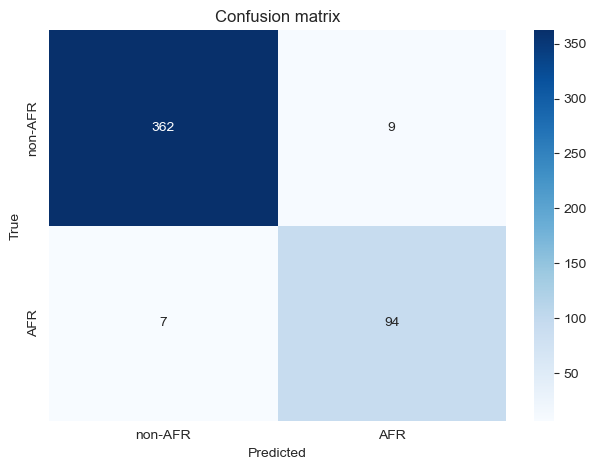

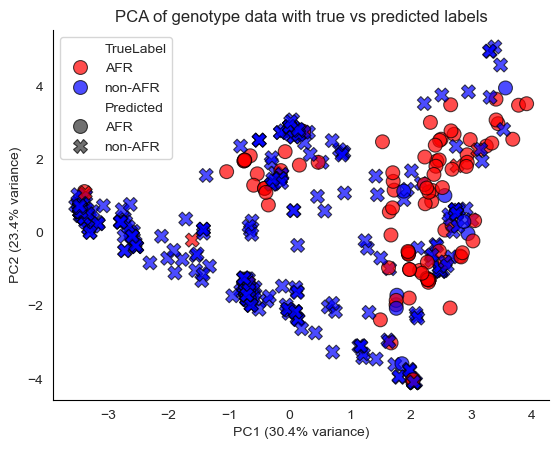

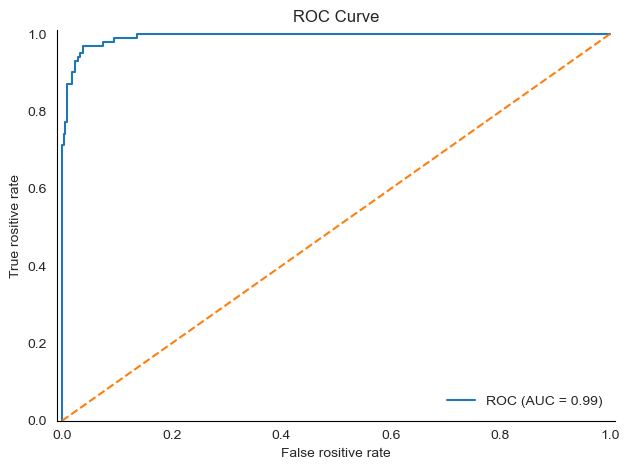

<Figure size 640x480 with 0 Axes>

In [7]:
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(report)
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc * 100:.2f}%")
print(f"ROC AUC: {roc_auc:.2f}")

# === Save Graphs ===
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['non-AFR', 'AFR'], yticklabels=['non-AFR', 'AFR'])
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.grid(False)
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
plt.savefig(os.path.join(graphs_folder, f"confusion_matrix_{date}.svg"))
plt.show()
plt.clf()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'TrueLabel': ['AFR' if y == 1 else 'non-AFR' for y in y_test],
    'Predicted': ['AFR' if y == 1 else 'non-AFR' for y in y_pred],
    'Sample': X_test.index
})
sns.scatterplot(data=pca_df, x='PC1', y='PC2',
                hue='TrueLabel',
                style='Predicted',
                s=100,
                edgecolor='black',
                palette={'AFR': 'red', 'non-AFR': 'blue'},
                alpha=0.7,
                )
plt.title("PCA of genotype data with true vs predicted labels")
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
xlabel = f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)"
ylabel = f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)"
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.grid(False)
plt.savefig(os.path.join(graphs_folder, f"pca_plot_{date}.svg"))
plt.show()
plt.clf()

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right',frameon=False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.grid(False)
# Set x and y axis labels for the ROC curve
xlabel = 'False rositive rate'
ylabel = 'True rositive rate'
plt.xlabel(xlabel)
plt.ylabel(ylabel)
# set x and y axis limits 0-1
plt.xlim(-0.01, 1.01)
plt.ylim(0, 1.01)
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
plt.savefig(os.path.join(graphs_folder, f"roc_curve_{date}.svg"))
plt.show()
plt.clf()


## === Display the top 10 important snps ===

In [8]:
top_10_snps = importance_df.head(10)
display(top_10_snps)

,SNP,Importance
199,chr19_44921082,0.079327
152,chr19_44917086,0.074871
202,chr19_44921257,0.048846
35,chr19_44905579,0.043793
89,chr19_44911194,0.043177
161,chr19_44917997,0.035471
104,chr19_44913221,0.035201
167,chr19_44918620,0.033533
138,chr19_44915704,0.033160
38,chr19_44905910,0.031589
